<a href="https://colab.research.google.com/github/sahin-arslan/YapaySinirAglari/blob/main/234312029_Sahin_Arslan_YSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Gerekli Kütüphanelerin Yüklenmesi


*   pandas, numpy (veri işleme)
*   sklearn, keras (model oluşturma, veri ayırma, performans metrikleri)
*   matplotlib ve seaborn (görselleştirme)




In [ ]:
!pip install scikeras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

## 2. Veri Seti Yükleme ve Ön İşleme



**1. Veri Yükleme:**

In [ ]:
#Transformation tanımını yapıyoruz
transform = transforms.Compose([
       transforms.Resize((32, 32)), # Resimleri 32X32 olarak düzenliyoruz
       transforms.ToTensor(),  # Resimleri PyTorch tensor'lere dönüştürüyoruz
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Piksel değerlerini normalize ediyoruz.
   ])

In [ ]:
#GTSRB Veri setinin yüklüyoruz.
dataset = torchvision.datasets.GTSRB(
       root='./data',
       split='train',
       download=True,
       transform=transform
)

100%|██████████| 187M/187M [00:06<00:00, 30.0MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


**2.	Eksik Değerlerin İşlenmesi:** Eğer veri setinde eksik değerler varsa, uygun yöntemlerle doldurulmalıdır.

Veri seti boyutu: 26640


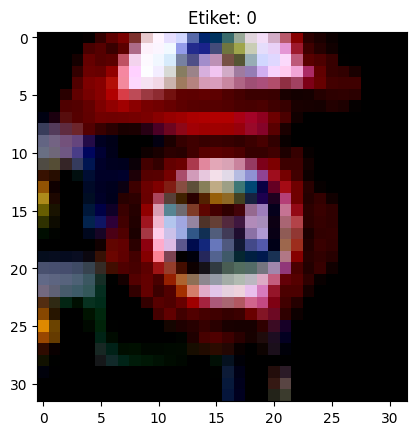

In [ ]:
print(f"Veri seti boyutu: {len(dataset)}")

# Örnek bir görüntü gösteriyoruz
if len(dataset) > 0:
    image, label = dataset[0]
    plt.imshow(image.permute(1, 2, 0)) # Tenosörleri görselleştirmek için permütasyon yapıyoruz.
    plt.title(f"Etiket: {label}")
    plt.show()

**3.	Veri Setini Eğitim ve Test Olarak Ayırma:**

*   Veriyi %80 eğitim, %20 test olarak ikiye ayırın.
*   sklearn.model_selection.train_test_split fonksiyonunu kullanın.


In [ ]:
# Veri setini eğitim ve test kümelerine ayırıyoruz
train_data, test_data = train_test_split(dataset,
                                         test_size=0.2,
                                         random_state=42)

print(f"Eğitim veri seti boyutu\t: {len(train_data)}")
print(f"Test veri seti boyutu\t:  {len(test_data)}")

Eğitim veri seti boyutu	: 21312
Test veri seti boyutu	:  5328


**4.	Özellik Ölçekleme (Feature Scaling):**

*   Verileri MLP ve RBF için uygun hale getirmek adına standartlaştırın (örn. StandartScaler veya MinMaxScaler kullanarak).


In [ ]:

# Veri setini NumPy dizilerine dönüştürüyoruz
X_train = np.array([np.array(image) for image, _ in train_data])
y_train = np.array([label for _, label in train_data])
X_test = np.array([np.array(image) for image, _ in test_data])
y_test = np.array([label for _, label in test_data])


# Verileri düzleştirme (MLP ve RBF için)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# StandardScaler kullanarak verileri standartlaştırıyoruz
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (21312, 3072)
X_test_scaled shape: (5328, 3072)


## 3. Model Eğitimi ve Hiperparametre Denemeleri
**1.	MLP Modeli:**

*   sklearn.neural_network.MLPClassifier kullanarak bir MLP modeli oluşturun.



In [ ]:
# MLP modelini oluşturuyoruz
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50),  # Örnek katman yapılandırması
                          activation='relu',            # Aktivasyon fonksiyonu
                          solver='adam',                # Optimizasyon algoritması
                          max_iter=20,                 # Maksimum iterasyon sayısı (azaltılmış)
                          random_state=42)             # Rastgelelik için seed değeri

# Modeli eğitim verileri ile eğitiyoruz
mlp_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20, random_state=42)

*   Hiperparametre denemeleri için farklı katman sayıları, nöron sayıları ve aktivasyon fonksiyonlarını test edin (örn. hidden_layer_sizes, activation ve learning_rate gibi parametreler).

In [ ]:
# Parametre ızgarasını tanımlıyoruz
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Farklı katman yapıları
    'activation': ['relu', 'tanh', 'logistic'],  # Farklı aktivasyon fonksiyonları
    'learning_rate_init': [0.001, 0.01, 0.1]  # Farklı öğrenme oranları
}

# GridSearchCV kullanarak en iyi hiperparametreleri buluyoruz
grid_search = GridSearchCV(estimator=MLPClassifier(max_iter=20, random_state=42),  # max_iter azaltıldı
                           param_grid=param_grid,
                           scoring='accuracy',  # Performans ölçütü olarak doğruluk kullanıldı
                           cv=3,  # 3 katlı çapraz doğrulama
                           n_jobs=-1) # Tüm işlemcileri kullan

grid_search.fit(X_train_scaled, y_train)

# En iyi hiperparametreleri ve performansı yazdırıyoruz
print("En iyi hiperparametreler:", grid_search.best_params_)
print("En iyi doğruluk skoru:", grid_search.best_score_)

# En iyi modeli kullanarak tahmin yapıyoruz
best_mlp_model = grid_search.best_estimator_
y_pred_mlp = best_mlp_model.predict(X_test_scaled)

En iyi hiperparametreler: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
En iyi doğruluk skoru: 0.9425206456456455


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


**2.	RBF Modeli:**

*   sklearn kütüphanesinde doğrudan RBF modeli bulunmadığından, KEras kütüphanesi kullanın

*   Alternatif olarak, rbfnetwork gibi özel kütüphaneler veya Python’da yazılmış RBF fonksiyonları kullanılabilir.


In [ ]:
# RBF modeli oluşturuyoruz
rbf_model = Sequential()
rbf_model.add(Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],))) # Giriş katmanı
rbf_model.add(Dense(len(np.unique(y_train)), activation='softmax')) # Çıkış katmanı (sınıf sayısı kadar nöron)

rbf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitmini yapıyoruz
rbf_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1)

# Tahmin yapıyoruz
y_pred_rbf_prob = rbf_model.predict(X_test_scaled)
y_pred_rbf = np.argmax(y_pred_rbf_prob, axis=1) # Tahmin edilen olasılıkları sınıf etiketlerine dönüştürme


# Performans ölçümleri yapıyoruz
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"MLP Doğruluk: {accuracy_mlp}")
print(f"RBF Doğruluk: {accuracy_rbf}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4594 - loss: 2.3071
Epoch 2/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7891 - loss: 0.7764
Epoch 3/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8526 - loss: 0.5292
Epoch 4/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8788 - loss: 0.4323
Epoch 5/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9027 - loss: 0.3423
Epoch 6/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9136 - loss: 0.3015
Epoch 7/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9151 - loss: 0.2952
Epoch 8/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9144 - loss: 0.3046
Epoch 9/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9237 - loss: 0.2845
Epoch 10/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9191 - loss: 0.3087
Epoch 11/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9481 - loss: 0.1863
Epoch 12/20
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/ste

## 4. Performans Ölçümleri


**1.	Confusion Matrix:**

*   Her iki model için tahminleri değerlendirerek karışıklık matrisini (confusion_matrix) oluşturun.

*   seaborn kullanarak karışıklık matrisini görselleştirin.


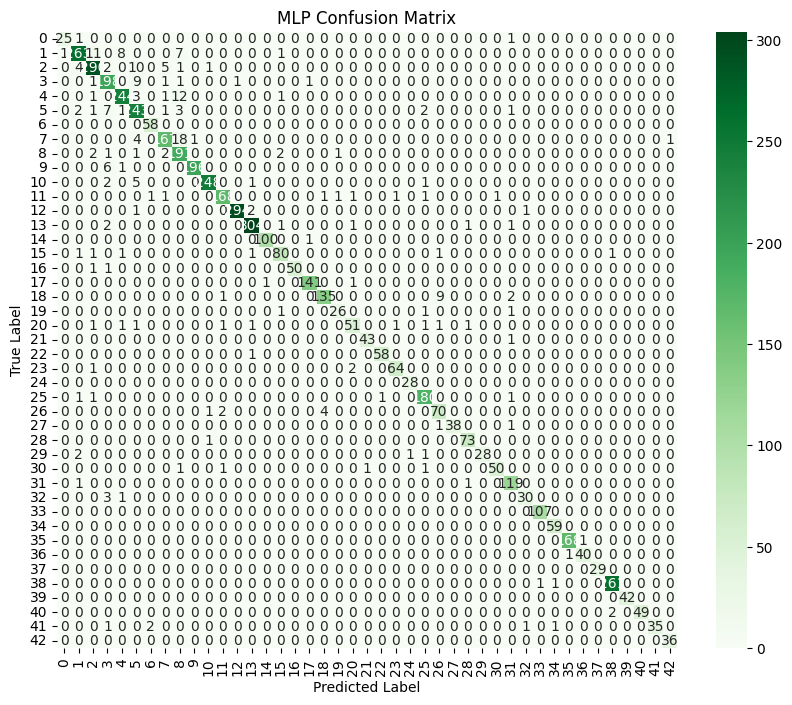

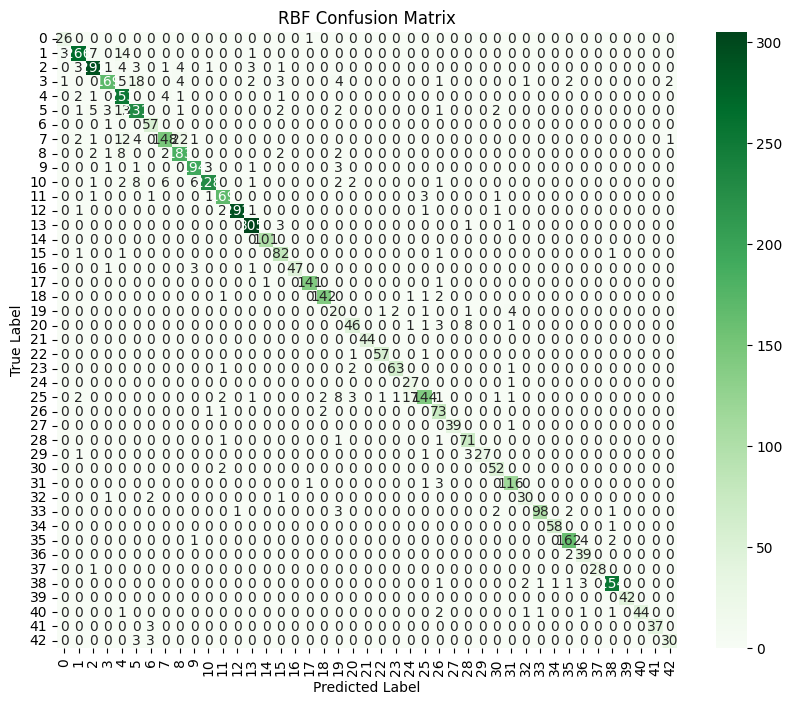

In [ ]:
# MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Greens")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# RBF Confusion Matrix
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap="Greens")
plt.title("RBF Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**2.	Performans Metrikleri:**
*   Her iki model için accuracy, precision, recall, ve F1-score gibi metriklernden gerekli olanları hesaplayın (sklearn.metrics.classification_report fonksiyonunu kullanarak).


In [ ]:

# MLP Performance Metrics
print("MLP Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_mlp))

# RBF Performance Metrics
print("RBF Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rbf))

MLP Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.96      0.90      0.93       291
           2       0.93      0.93      0.93       313
           3       0.89      0.93      0.91       212
           4       0.95      0.93      0.94       262
           5       0.88      0.93      0.90       261
           6       0.95      1.00      0.97        58
           7       0.94      0.87      0.91       191
           8       0.82      0.95      0.88       200
           9       0.99      0.97      0.98       203
          10       0.99      0.96      0.98       257
          11       0.97      0.95      0.96       176
          12       1.00      0.99      0.99       298
          13       0.98      0.98      0.98       310
          14       0.99      0.99      0.99       101
          15       0.93      0.93      0.93        86
          16       1.00      0.96      0.98        52
 

##5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma



**1.	Hiperparametre Denemeleri:**

*   MLP ve RBF modelleri için farklı hiperparametreleri deneyin ve her denemede eğitim ve test sonuçlarını kaydedin.


*   GridSearchCV veya RandomizedSearchCV ile hiperparametre optimizasyonu yaparak en iyi parametreleri bulun.



In [ ]:
#RandomizedSearchCV için parametre dağılımlarını tanımlıyoruz
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# RandomizedSearchCV nesnesini oluşturuyoruz
random_search_mlp = RandomizedSearchCV(
    estimator=MLPClassifier(max_iter=20, random_state=42),
    param_distributions=mlp_param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Modelimizi eğitiyoruz
random_search_mlp.fit(X_train_scaled, y_train)

print("En iyi MLP hiperparametreler: ", random_search_mlp.best_params_)
print("En iyi MLP doğruluk skoru: ", random_search_mlp.best_score_)

# Test veri seti ile en iyi model parametrelerini belirliyoruz
best_mlp_model = random_search_mlp.best_estimator_
y_pred_mlp_rs = best_mlp_model.predict(X_test_scaled)
accuracy_mlp_rs = accuracy_score(y_test, y_pred_mlp_rs)
print(f"MLP (RandomizedSearchCV) Doğruluğu : {accuracy_mlp_rs}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
En iyi MLP hiperparametreler:  {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'activation': 'logistic'}
En iyi MLP doğruluk skoru:  0.9425206456456455
MLP (RandomizedSearchCV) Doğruluğu : 0.9532657657657657


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# RBF modelimizi oluşturuyoruz
def create_rbf_model(neurons=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

rbf_model = KerasClassifier(build_fn=create_rbf_model, epochs=20, batch_size=32, verbose=0)

#RandomizedSearchCV için parametre dağılımlarını tanımlıyoruz
param_dist = {
    'model__neurons': [50, 100, 150],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'sgd'],
    'epochs': [10, 20, 30]
}

# RandomizedSearchCV nesnesini oluşturuyoruz
random_search_rbf = RandomizedSearchCV(
    estimator=rbf_model,
    param_distributions=param_dist,
    n_iter=10,  # Örnek sayısı
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Modelimizi eğitiyoruz
random_search_rbf.fit(X_train_scaled, y_train)


print("En iyi RBF hiperparametreler: ", random_search_rbf.best_params_)
print("En iyi RBF doğruluk skoru:", random_search_rbf.best_score_)

# Test veri seti ile en iyi model parametrelerini belirliyoruz
best_rbf_model = random_search_rbf.best_estimator_
y_pred_rbf_rs = best_rbf_model.predict(X_test_scaled)
accuracy_rbf_rs = accuracy_score(y_test, y_pred_rbf_rs)
print(f"RBF (RandomizedSearchCV) Doğruluğu : {accuracy_rbf_rs}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


En iyi RBF hiperparametreler:  {'model__optimizer': 'sgd', 'model__neurons': 150, 'model__activation': 'tanh', 'epochs': 30}
En iyi RBF doğruluk skoru: 0.9461805555555555
RBF (RandomizedSearchCV) Doğruluğu : 0.9592717717717718


**2.	Sonuçları Karşılaştırma ve Yorumlama:**

*   MLP ve RBF modellerinin sonuçlarını karşılaştırarak hangi modelin daha iyi performans gösterdiğini analiz edin.
*   Sonuçları tablo veya grafik olarak sunun ve performans farklılıklarının nedenlerini tartışın.


  Model  Accuracy
0   MLP  0.953266
1   RBF  0.959272


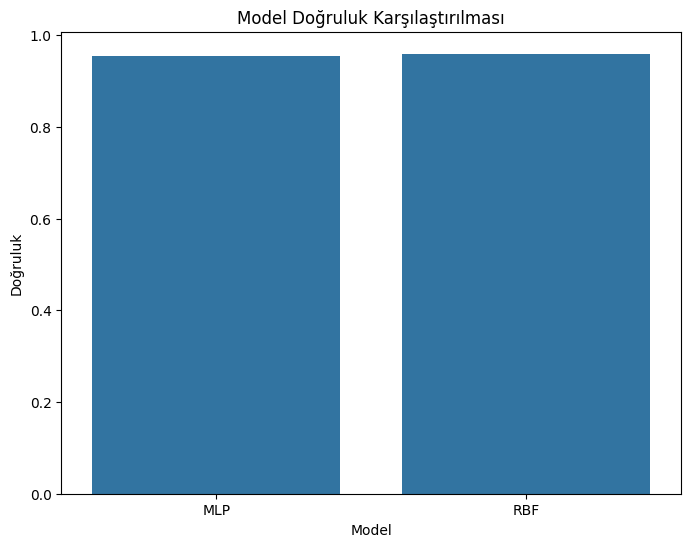

RBF modelinin performansı MLP modelinin performansından daha iyi


In [ ]:
# Model performanslarını karşılaştırmak için dataframe oluşturuyoruz
results = pd.DataFrame({
    'Model': ['MLP', 'RBF'],
    'Accuracy': [accuracy_mlp_rs, accuracy_rbf_rs],
    # Add other metrics as needed (e.g., precision, recall, F1-score)
})

# Sonuçları yazdırıyoruz
print(results)

# Karşılaştırma için bar grafiği oluşturuyoruz
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Doğruluk Karşılaştırılması')
plt.ylabel('Doğruluk')
plt.show()


# Performans farklarını analiz ediyoruz
if accuracy_mlp_rs > accuracy_rbf_rs:
    print("MLP modelinin performansı RBF modelinin performansından daha iyi")

elif accuracy_rbf_rs > accuracy_mlp_rs:
    print("RBF modelinin performansı MLP modelinin performansından daha iyi")
else:
    print("İki modelin performansları benzer")

